# Регрессионный анализ: Auto-MPG

- Корреляционный анализ; базовая линейная модель; выводы (коэффициенты, t-test, F-test);
- Диагностика: графики (scatter с линией регрессии, Residuals vs Fitted, Normal Q-Q), VIF, тесты на гетероскедастичность, автокорреляцию, нормальность остатков;
- Stepwise (AIC) подбор модели и повторный анализ для улучшенной модели;
- Box–Cox трансформация отклика и анализ новой модели;

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

plt.rcParams['figure.figsize'] = (8,5)

## Загрузка и предобработка

In [17]:
columnNames = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
autoMpgDataFrame = pd.read_csv('datasets/auto-mpg.data', delim_whitespace=True, names=columnNames, na_values='?')
autoMpgDataFrame = autoMpgDataFrame.dropna().reset_index(drop=True)
print('Размер выборки:', len(autoMpgDataFrame))
display(autoMpgDataFrame.head())

autoMpgDataFrame['origin_europe'] = (autoMpgDataFrame['origin'] == 2).astype(int)
autoMpgDataFrame['origin_japan'] = (autoMpgDataFrame['origin'] == 3).astype(int)

Размер выборки: 392


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### Корреляционный анализ
Построим матрицу корреляций по числовым переменным и тепловую карту.

Correlation matrix:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.244313,0.451454
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.352324,-0.404209
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.371633,-0.440825
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.284948,-0.321936
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.293841,-0.447929
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.208298,0.115020
model_year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,-0.037745,0.199841
origin_europe,0.244313,-0.352324,-0.371633,-0.284948,-0.293841,0.208298,-0.037745,1.000000,-0.230157
origin_japan,0.451454,-0.404209,-0.440825,-0.321936,-0.447929,0.115020,0.199841,-0.230157,1.000000


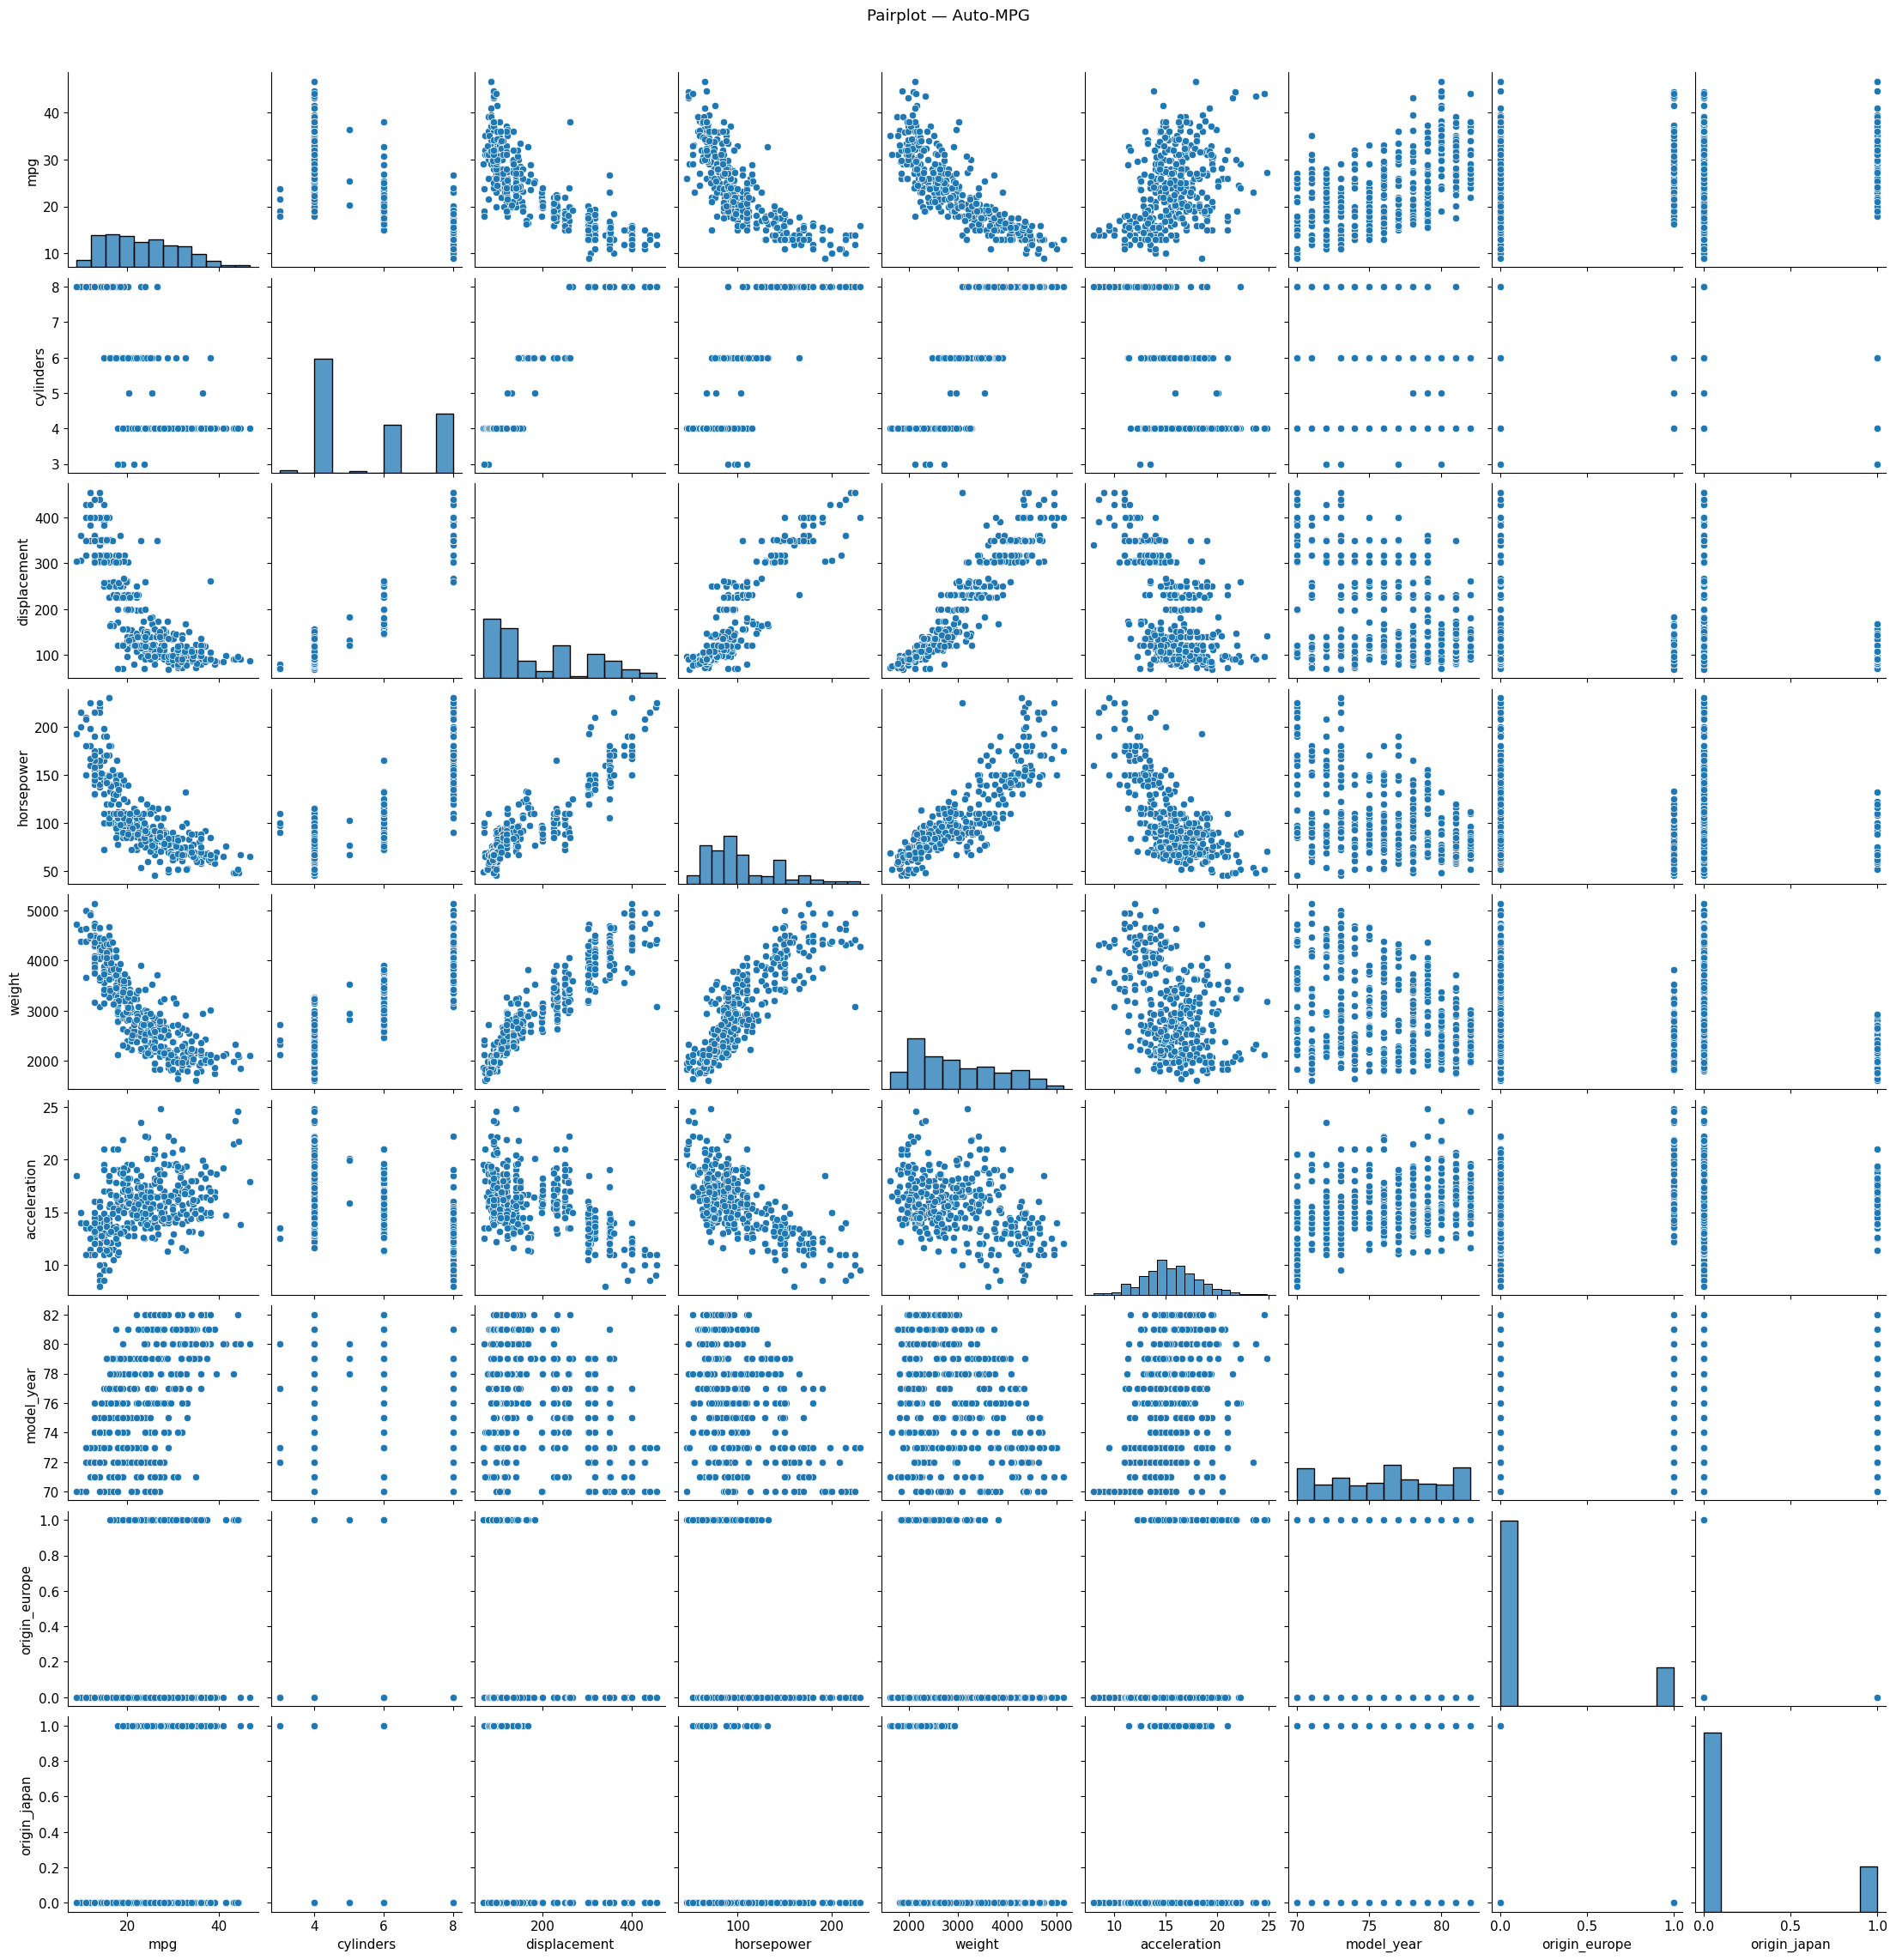

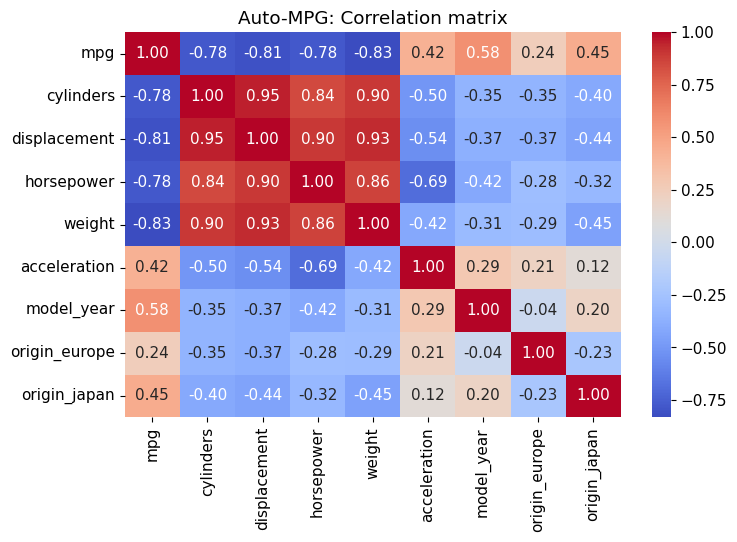

In [18]:
features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin_europe', 'origin_japan']
numDataAuto = autoMpgDataFrame[['mpg'] + features].dropna()
corrMatrixAuto = numDataAuto.corr()
print('Correlation matrix:')
display(corrMatrixAuto)

sns.pairplot(numDataAuto)
plt.suptitle('Pairplot — Auto-MPG', y=1.02)
plt.show()

plt.figure()
sns.heatmap(corrMatrixAuto, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Auto-MPG: Correlation matrix')
plt.show()

### Построение базовой модели линейной регрессии
Будем моделировать `mpg` как функцию `cylinders + displacement + horsepower + weight + acceleration + model_year + origin_europe + origin_japan`.

In [19]:
yAuto = numDataAuto['mpg']
XAuto = numDataAuto[features]
XAutoWithConst = sm.add_constant(XAuto)

baseModelAuto = sm.OLS(yAuto, XAutoWithConst).fit()
print('--- Base model summary ---')
print(baseModelAuto.summary())

--- Base model summary ---
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          1.79e-139
Time:                        17:22:39   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -17

### Вывод результатов базовой модели
Стандартный `summary()` уже содержит коэффициенты, стандартные ошибки, t-statistics, p-values, R-squared и F-statistic.

In [20]:
coefficientsAuto = baseModelAuto.params
stdErrAuto = baseModelAuto.bse
tValuesAuto = baseModelAuto.tvalues
pValuesAuto = baseModelAuto.pvalues
fStatisticAuto = baseModelAuto.fvalue
fPvalueAuto = baseModelAuto.f_pvalue

print('\nCoefficients:\n', coefficientsAuto, sep='')
print('\nStd. errors:\n', stdErrAuto, sep='')
print('\nT-statistics:\n', tValuesAuto, sep='')
print('\nP-values:\n', pValuesAuto, sep='')
print('\nF-statistic = ', fStatisticAuto, ', F p-value = ', fPvalueAuto, sep='')


Coefficients:
const           -17.954602
cylinders        -0.489709
displacement      0.023979
horsepower       -0.018183
weight           -0.006710
acceleration      0.079103
model_year        0.777027
origin_europe     2.630002
origin_japan      2.853228
dtype: float64

Std. errors:
const            4.676934
cylinders        0.321231
displacement     0.007653
horsepower       0.013709
weight           0.000655
acceleration     0.098218
model_year       0.051784
origin_europe    0.566415
origin_japan     0.552736
dtype: float64

T-statistics:
const            -3.838969
cylinders        -1.524478
displacement      3.133124
horsepower       -1.326428
weight          -10.242779
acceleration      0.805378
model_year       15.005130
origin_europe     4.643246
origin_japan      5.162006
dtype: float64

P-values:
const            1.445124e-04
cylinders        1.282146e-01
displacement     1.862685e-03
horsepower       1.854885e-01
weight           6.375633e-22
acceleration     4.211012e-01


### Уравнение линейной регрессии
Запишем уравнение в явном виде с коэффициентами из модели.

In [21]:
interceptAuto = coefficientsAuto['const']
termsAuto = []
for name in features:
    coef = coefficientsAuto[name]
    termsAuto.append(f"({coef:.4f})*{name}")
equationAuto = f"mpg = {interceptAuto:.4f} + " + ' + '.join(termsAuto)
print('Regression equation:')
print(equationAuto)

Regression equation:
mpg = -17.9546 + (-0.4897)*cylinders + (0.0240)*displacement + (-0.0182)*horsepower + (-0.0067)*weight + (0.0791)*acceleration + (0.7770)*model_year + (2.6300)*origin_europe + (2.8532)*origin_japan


### T-test значимости коэффициентов
Статистики t и p-values для каждого коэффициента.

In [22]:
identityMatrix = np.eye(len(baseModelAuto.params))
ttestAll = baseModelAuto.t_test(identityMatrix)
print(ttestAll.summary())

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0           -17.9546      4.677     -3.839      0.000     -27.150      -8.759
c1            -0.4897      0.321     -1.524      0.128      -1.121       0.142
c2             0.0240      0.008      3.133      0.002       0.009       0.039
c3            -0.0182      0.014     -1.326      0.185      -0.045       0.009
c4            -0.0067      0.001    -10.243      0.000      -0.008      -0.005
c5             0.0791      0.098      0.805      0.421      -0.114       0.272
c6             0.7770      0.052     15.005      0.000       0.675       0.879
c7             2.6300      0.566      4.643      0.000       1.516       3.744
c8             2.8532      0.553      5.162      0.000       1.766       3.940


### F-test значимости уравнения регрессии
F-statistic и его p-value.

In [23]:
fStat = baseModelAuto.fvalue
fPvalue = baseModelAuto.f_pvalue
dfModel = int(baseModelAuto.df_model)
dfResid = int(baseModelAuto.df_resid)
print(f'F-статистика = {fStat:.6f}')
print(f'p-значение для F = {fPvalue:.6f}')
print(f'df_model = {dfModel}, df_resid = {dfResid}')

F-статистика = 224.450686
p-значение для F = 0.000000
df_model = 8, df_resid = 383


### Scatterplots и линия регрессии
Построим scatter `mpg` против каждого предиктора и линию предсказаний (прочие предикторы зафиксированы на средних).

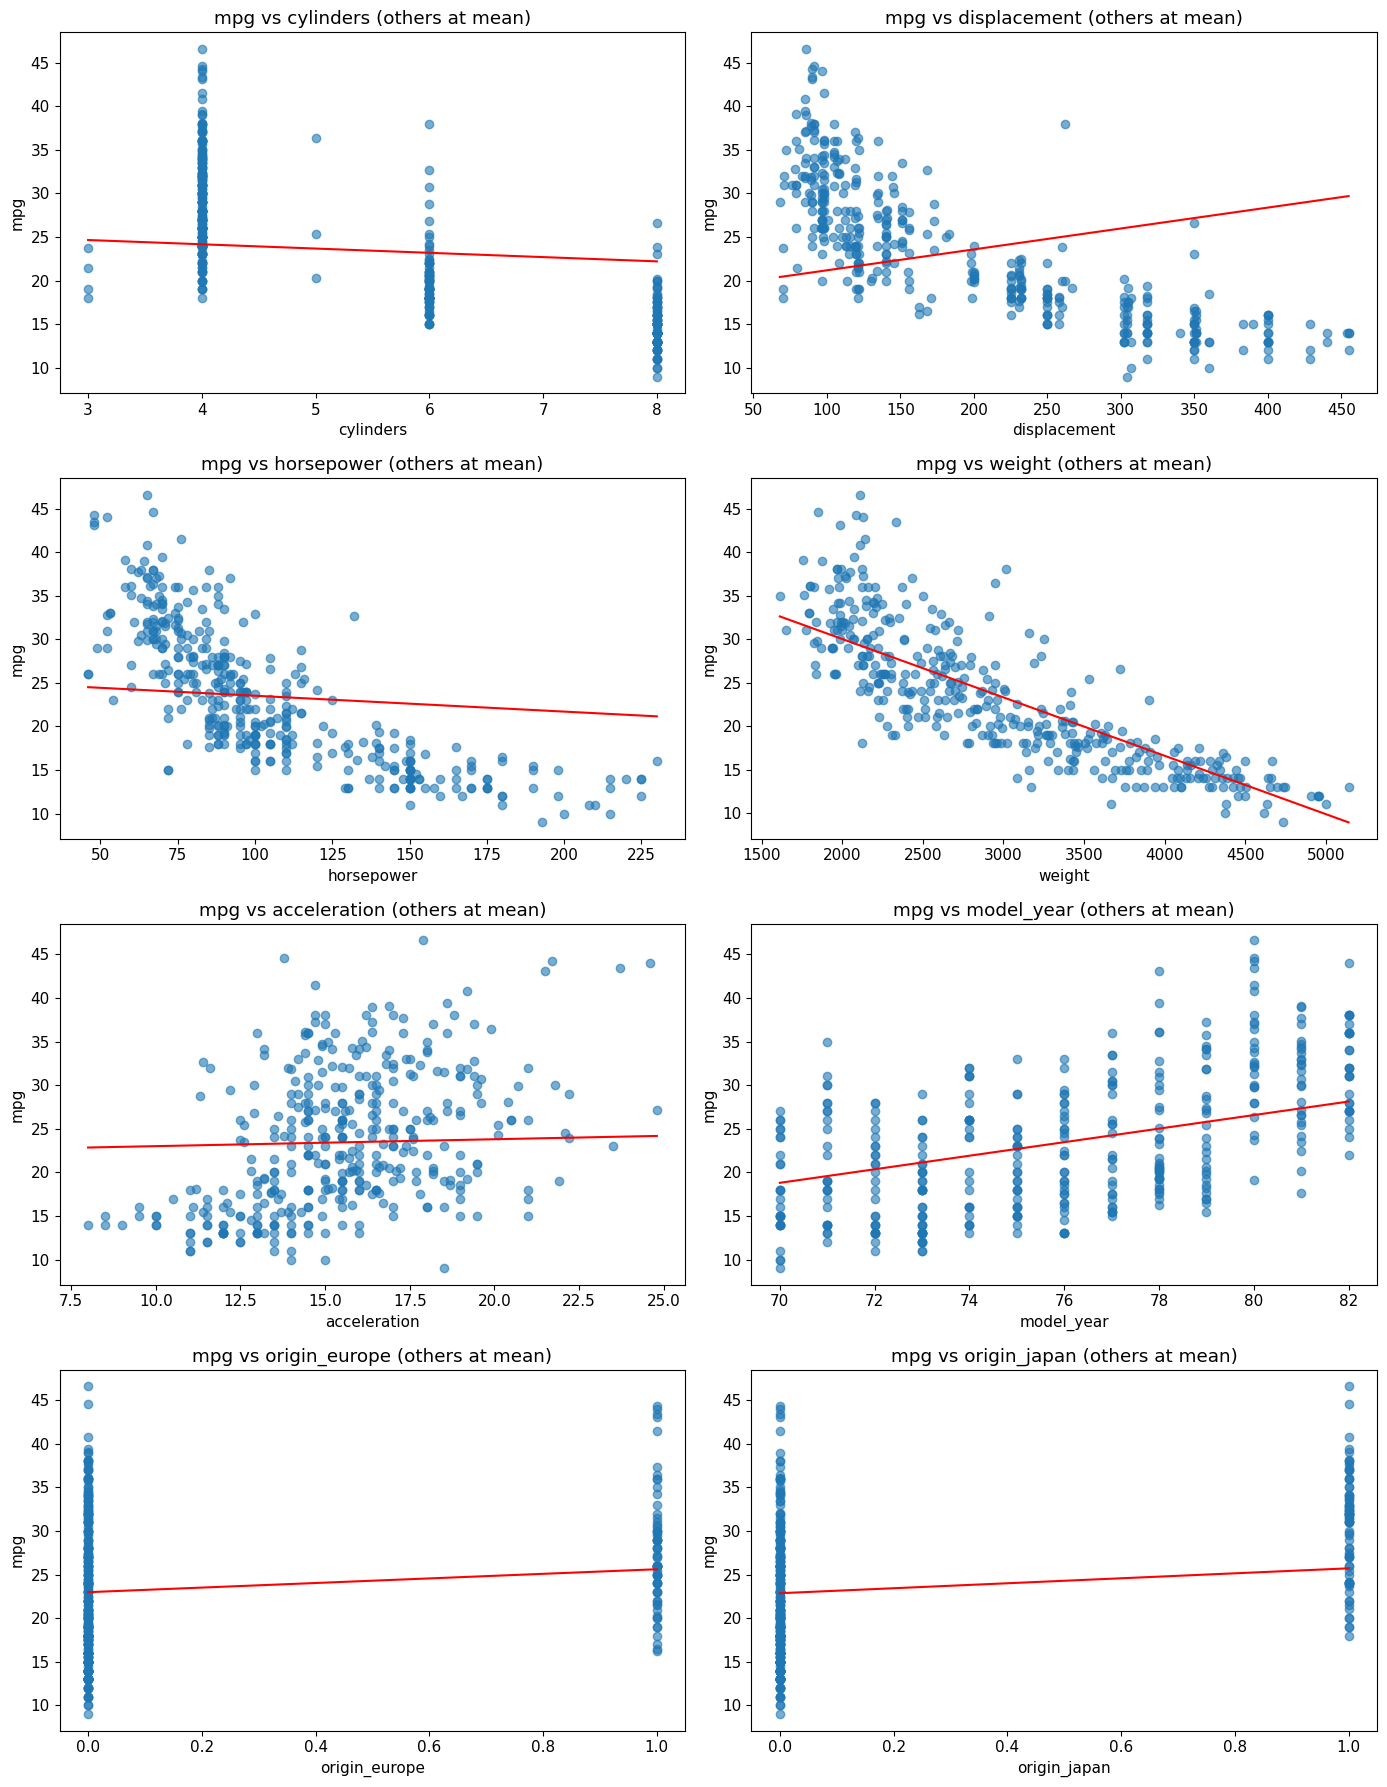

In [24]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.flatten()

for index, xVar in enumerate(features):
    currentAxis = axes[index]
    currentAxis.scatter(numDataAuto[xVar], yAuto, alpha=0.6)

    xGrid = np.linspace(numDataAuto[xVar].min(), numDataAuto[xVar].max(), 100)
    meanValues = XAuto.mean()

    predDataFrame = pd.DataFrame({
        column: np.full_like(xGrid, meanValues[column]) for column in features
    })
    predDataFrame[xVar] = xGrid

    predDataFrame = sm.add_constant(predDataFrame, has_constant='add')
    yPredLine = baseModelAuto.predict(predDataFrame[baseModelAuto.params.index])

    currentAxis.plot(xGrid, yPredLine, color='red')
    currentAxis.set_xlabel(xVar)
    currentAxis.set_ylabel('mpg')
    currentAxis.set_title(f'mpg vs {xVar} (others at mean)')

plt.tight_layout()
plt.show()


### Доверительные интервалы для коэффициентов регрессии
Используем `conf_int()` из результатов модели.

In [25]:
ciAuto = baseModelAuto.conf_int(alpha=0.05)
ciAuto.columns = ['CI_lower','CI_upper']
print('95% confidence intervals for coefficients:')
display(ciAuto)

95% confidence intervals for coefficients:


,CI_lower,CI_upper
const,-27.150283,-8.758921
cylinders,-1.121306,0.141887
displacement,0.008931,0.039026
horsepower,-0.045137,0.008770
weight,-0.007998,-0.005422
acceleration,-0.114012,0.272218
model_year,0.675210,0.878844
origin_europe,1.516331,3.743674
origin_japan,1.766451,3.940006


### Stepwise selection по AIC (forward-backward)
Реализуем простую функцию stepwiseSelection, которая выбирает переменные по минимальному AIC.

In [26]:
def stepwiseSelection(X, y, initialList=[], verbose=True):
    included = list(initialList)
    while True:
        changed = False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        bestAic = np.inf
        bestToAdd = None
        for newCol in excluded:
            tryCols = included + [newCol]
            model = sm.OLS(y, sm.add_constant(X[tryCols])).fit()
            aic = model.aic
            if aic < bestAic:
                bestAic = aic
                bestToAdd = newCol

        currentAic = sm.OLS(y, sm.add_constant(X[included])).fit().aic if included else np.inf
        if bestToAdd is not None and bestAic + 1e-8 < currentAic:
            included.append(bestToAdd)
            changed = True
            if verbose:
                print('Add {:30} with AIC {:.6f}'.format(bestToAdd, bestAic))
        
        # Backward step
        bestAic = np.inf
        worstToRemove = None
        if included:
            for col in included:
                tryCols = [c for c in included if c != col]
                model = sm.OLS(y, sm.add_constant(X[tryCols])).fit()
                aic = model.aic
                if aic < bestAic:
                    bestAic = aic
                    worstToRemove = col
                    
            currentAic = sm.OLS(y, sm.add_constant(X[included])).fit().aic
            if worstToRemove is not None and bestAic + 1e-8 < currentAic:
                included.remove(worstToRemove)
                changed = True
                if verbose:
                    print('Remove {:30} to improve AIC to {:.6f}'.format(worstToRemove, bestAic))
        
        if not changed:
            break

    return included

selectedVarsAuto = stepwiseSelection(XAuto, yAuto, verbose=True)
print('\nSelected variables by stepwise AIC:', selectedVarsAuto)

Add weight                         with AIC 2263.938549
Add model_year                     with AIC 2081.112514
Add origin_japan                   with AIC 2074.753452
Add origin_europe                  with AIC 2062.278139
Add displacement                   with AIC 2060.766188
Add horsepower                     with AIC 2058.092481
Add cylinders                      with AIC 2057.591140

Selected variables by stepwise AIC: ['weight', 'model_year', 'origin_japan', 'origin_europe', 'displacement', 'horsepower', 'cylinders']


### Если модель улучшилась — повторим диагностику
Если `selectedVarsAuto` отличается от исходного набора, подгоним новую модель и повторим диагностику.

In [27]:
if set(selectedVarsAuto) != set(features):
    print('Fitting improved model with vars:', selectedVarsAuto)
    XAutoSelected = sm.add_constant(XAuto[selectedVarsAuto])
    improvedModelAuto = sm.OLS(yAuto, XAutoSelected).fit()
    print(improvedModelAuto.summary())
else:
    print('Stepwise did not change the model (selected == full).')

Fitting improved model with vars: ['weight', 'model_year', 'origin_japan', 'origin_europe', 'displacement', 'horsepower', 'cylinders']
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     256.7
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          1.49e-140
Time:                        17:22:40   Log-Likelihood:                -1020.8
No. Observations:                 392   AIC:                             2058.
Df Residuals:                     384   BIC:                             2089.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      

### Построить diagnostic-графики Residuals vs Fitted и Normal Q-Q

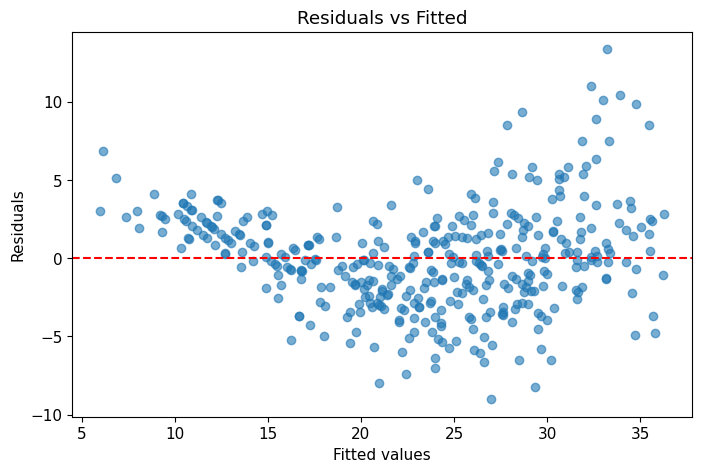

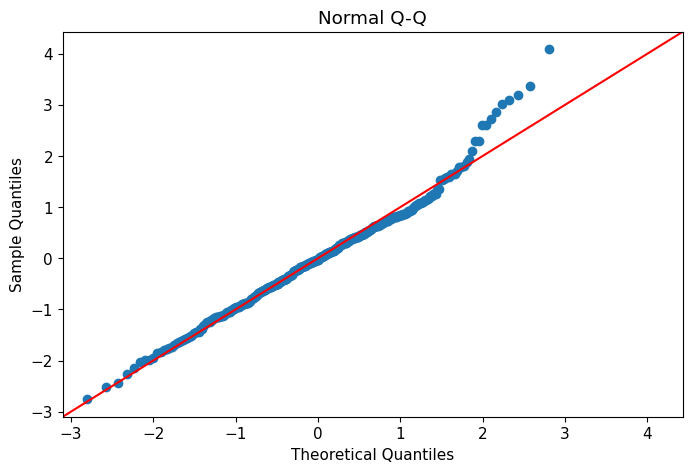

In [28]:
fittedVals = baseModelAuto.fittedvalues
residuals = baseModelAuto.resid
plt.figure()
plt.scatter(fittedVals, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal Q-Q')
plt.show()

### Тест на гетероскедастичность
Breusch–Pagan тест.

In [29]:
bpTest = het_breuschpagan(residuals, baseModelAuto.model.exog)
bpStat, bpPvalue = bpTest[0], bpTest[1]
print('\nBreusch-Pagan: statistic =', bpStat, ', p-value =', bpPvalue)


Breusch-Pagan: statistic = 35.08640087220573 , p-value = 2.5786676813862798e-05


### Тест на автокорреляцию остатков
Durbin–Watson тест.

In [30]:
dwStat = durbin_watson(residuals)
print('\nDurbin-Watson statistic =', dwStat)


Durbin-Watson statistic = 1.291374322006077


### Нормальность остатков
Shapiro и Jarque–Bera тест.

In [31]:
jbStat, jbPvalue, skewResid, kurtResid = sm.stats.stattools.jarque_bera(residuals)
shStatRes, shPRes = sps.shapiro(residuals)
print('\nJarque-Bera: stat =', jbStat, ', p-value =', jbPvalue)
print('Shapiro-Wilk on residuals: stat =', shStatRes, ', p-value =', shPRes)


Jarque-Bera: stat = 34.45223489146021 , p-value = 3.302115415912762e-08
Shapiro-Wilk on residuals: stat = 0.9824311658860396 , p-value = 0.00010609193877518682


### Мультиколлинеарность
VIF для каждой регрессора.

In [32]:
vifData = pd.DataFrame()
vifData['feature'] = features
vifData['VIF'] = [variance_inflation_factor(XAuto.values, i) for i in range(XAuto.shape[1])]
print('\nVIF:')
display(vifData)


VIF:


,feature,VIF
0,cylinders,117.521073
1,displacement,102.104942
2,horsepower,67.115852
3,weight,140.876665
4,acceleration,70.183974
5,model_year,111.917294
6,origin_europe,1.922502
7,origin_japan,2.201570


### Попытка Box–Cox трансформации `mpg`

In [33]:
yBox, lambdaBox = sps.boxcox(yAuto)
print('Box-Cox lambda =', lambdaBox)

Box-Cox lambda = 0.19123084478293514



### Анализ новой модели. 

In [34]:
modelBoxAuto = sm.OLS(yBox, XAutoWithConst).fit()
print(modelBoxAuto.summary())
print('\nBase AIC =', baseModelAuto.aic, ', Box-Cox model AIC =', modelBoxAuto.aic)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     332.4
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          3.61e-167
Time:                        17:22:41   Log-Likelihood:                 41.877
No. Observations:                 392   AIC:                            -65.75
Df Residuals:                     383   BIC:                            -30.01
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5946      0.311      5.125